# Electricity Production 

Model to predict Electricity Generated (E) in MW based on ambient variables of the plant.

**The ambient variables of the power plant are:**

1. Temperature (T) in &deg;C
2. Ambient Pressure (P) in millibar
3. Relative Humidity (RH)
4. Exhaust Vacuum (V) in cm Hg

In [1]:
import numpy as np
import `pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Using Pandas to read data from csv

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
train_data.head()

,T,V,P,RH,E
0,273.39,420.12,91.84,57.41,1778.12
1,195.26,248.88,92.29,35.21,1824.16
2,377.52,360.42,92.31,27.69,1761.72
3,171.60,244.98,91.61,56.99,1889.64
4,222.56,353.70,92.43,54.25,1806.68


In [4]:
train_data.describe()

,T,V,P,RH,E
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,256.010820,325.217580,92.111935,44.169640,1817.052860
std,95.188288,76.288073,0.539140,8.773132,66.594563
min,47.190000,152.160000,90.260000,15.530000,1700.560000
25%,175.695000,250.680000,91.730000,37.997500,1758.960000
50%,266.565000,307.800000,92.080000,45.160000,1808.400000
75%,334.880000,398.700000,92.482500,51.152500,1871.620000
max,455.390000,481.080000,93.890000,60.090000,1976.960000


# Using Keras for neural network and sklearn for preprocessing, pipeline, metrics, etc.

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [6]:
X = train_data[['T', 'V', 'P', 'RH']].values
Y = train_data['E'].values
X_test = test_data.values

In [7]:
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [8]:
epochs = 500
batch_size = 100
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=epochs, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" %(results.mean(), results.std()))

Results: -291.84 (44.91) MSE


In [9]:
estimators[1][1].fit(X[:1800], Y[:1800])
pred = estimators[1][1].predict(X[1800:])
print("R2 Score:", r2_score(pred, Y[1800:]))

R2 Score: 0.9167796073330071


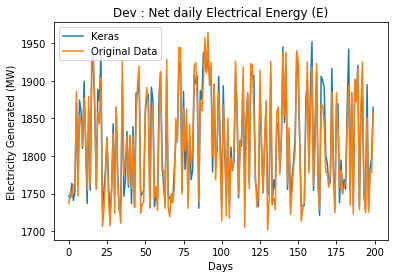

In [10]:
plt.plot(range(pred.shape[0]), pred, label='Keras')
plt.plot(range(pred.shape[0]), Y[1800:], label='Original Data')
plt.legend(loc='best')
plt.ylabel('Electricity Generated (MW)')
plt.xlabel('Days')
plt.title('Dev : Net daily Electrical Energy (E)')
plt.show()

In [11]:
estimators[1][1].fit(X, Y)
test_pred = estimators[1][1].predict(X_test)

In [12]:
pd.DataFrame(test_pred).to_csv('results_neural_net.csv', index=False, header=False)

# Using train_test_split and MinMaxScaler from sklearn

```
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
```

```
X = np.array(train_data[['T', 'V', 'P', 'RH']])
Y = np.array(train_data['E'])
X_test = np.array(test_data)

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.1)
```

# Using Tensorflow for neural network

```
import tensorflow as tf
```

```
def layer(A_in, layer_size):
    W = tf.Variable(tf.random_uniform([int(A_in.shape[1]), layer_size]))
    b = tf.Variable(tf.zeros([layer_size]))
    A_out = tf.nn.relu(tf.add(tf.matmul(A_in, W), b))
    
    return (W, b, A_out)
```

```
def neural_net_model(X_in, layers):

    W_prev, b_prev, A_prev = layer(X_in, layers[0])
    W = [W_prev]
    for layer_num in range(1, len(layers)-1):
        W_prev, b_prev, A_prev = layer(A_prev, layers[layer_num])
        W.append(W_prev)
    W_prev = tf.Variable(tf.random_uniform([int(A_prev.shape[1]), layers[-1]]))
    b_prev = tf.Variable(tf.zeros([layers[-1]]))
    A_prev = tf.add(tf.matmul(A_prev, W_prev), b_prev)
    W.append(W_prev)
    
    return (W, A_prev)
```

```
learning_rate = 0.001
epochs = 2500
batch_size = 100
beta = 0.0

x = tf.placeholder(tf.float32, [None, 4], name='x')
y = tf.placeholder(tf.float32, [None], name='y')

weights, output = neural_net_model(x, [32, 16, 8, 1])

regularizer = 0
for weight in weights:
    regularizer += tf.nn.l2_loss(weight)
cost = tf.reduce_mean(tf.square(output-y)+beta*regularizer)
    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    total_batch = X_train.shape[0] // batch_size
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = X_train[i*batch_size:(i+1)*batch_size], Y_train[i*batch_size:(i+1)*batch_size]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c/total_batch
        if epoch%100 == 0:
            print('Epoch :', (epoch), 'cost = {:.3f}'.format(avg_cost))
    
            train_pred = sess.run(output, feed_dict={x: X_train})

            plt.plot(range(Y_train.shape[0]), Y_train, label='Original Data')
            plt.plot(range(Y_train.shape[0]), train_pred, label='Predicted Data')
            plt.legend(loc='best')
            plt.ylabel('Electricity Generated (MW)')
            plt.xlabel('Days')
            plt.title('Train : Net daily Electrical Energy (E)')
            plt.show()

            dev_pred = sess.run(output, feed_dict={x: X_dev})
            print('Dev Cost :', sess.run(cost, feed_dict={x: X_dev, y: Y_dev}))

            plt.plot(range(Y_dev.shape[0]), Y_dev, label='Original Data')
            plt.plot(range(Y_dev.shape[0]), dev_pred, label='Predicted Data')
            plt.legend(loc='best')
            plt.ylabel('Electricity Generated (MW)')
            plt.xlabel('Days')
            plt.title('Dev : Net daily Electrical Energy (E)')
            plt.show()
    
    test_pred = sess.run(output, feed_dict={x: X_test})
```